In [3]:
%load_ext autoreload
%autoreload 2

In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from koala.pointsets import uniform
from koala import plotting as pl
from koala.voronization import generate_lattice
from koala.graph_color import color_lattice
from koala.hamiltonian import majorana_hamiltonian
from koala.flux_finder import ujk_from_fluxes, fluxes_from_ujk
import numpy as np
from tqdm import tqdm
import matplotlib
from koala.lattice import cut_boundaries
matplotlib.rcParams.update({'font.size': 30, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern'], 'figure.figsize': (10,10)})

In [10]:
points = uniform(2000)
lattice = generate_lattice(points)
# lattice = cut_boundaries(lattice)
coloring = color_lattice(lattice)

all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
target_flux = np.array([-1]*lattice.n_plaquettes)
ujk = ujk_from_fluxes(lattice,target_flux)
fluxes = fluxes_from_ujk(lattice, ujk)


 ...]

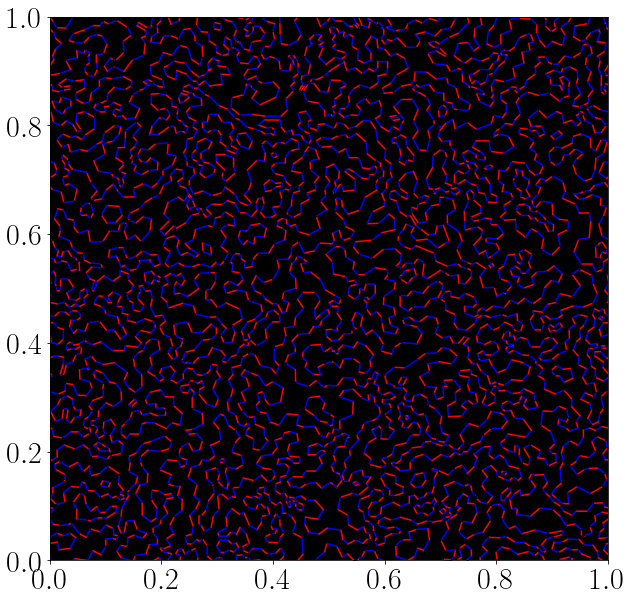

In [15]:
pl.plot_edges(lattice, labels=coloring)
pl.plot_plaquettes(lattice, fluxes)

In [12]:
ham = majorana_hamiltonian(lattice, coloring, ujk)

In [13]:
eig, vec = np.linalg.eigh(ham)

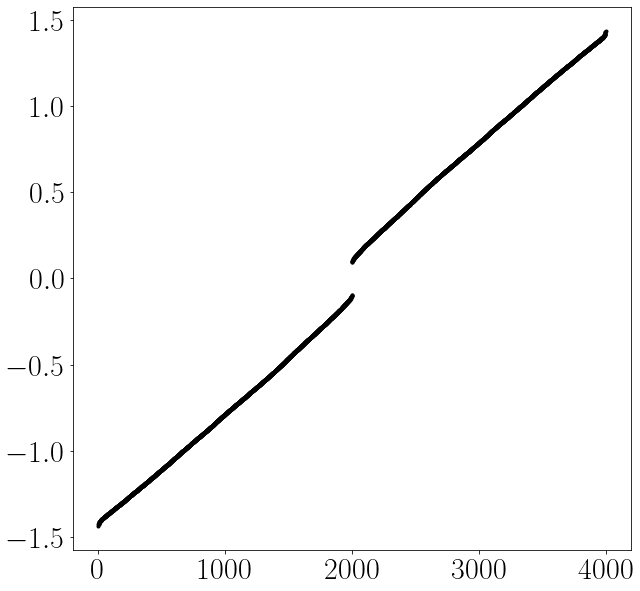

In [16]:
plt.plot(eig, 'k.')

In [17]:
sorted_vecs = vec[:, np.abs(eig).argsort()]

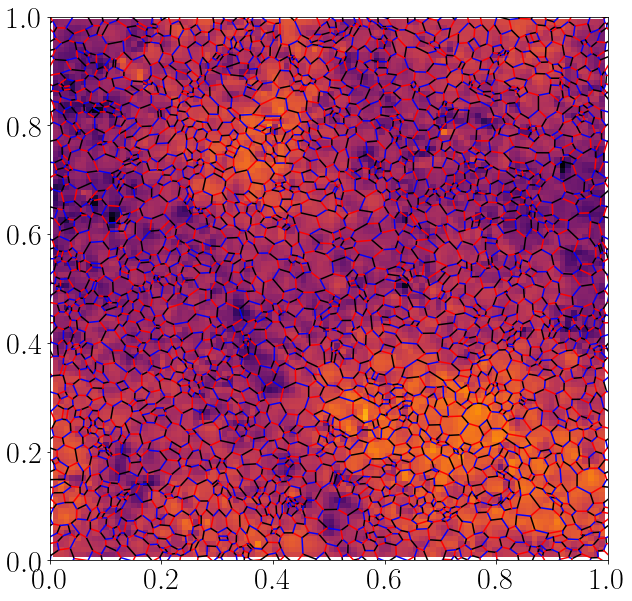

In [18]:

pl.plot_edges(lattice, labels=coloring)
pl.plot_scalar(lattice, np.log(np.abs(sorted_vecs[:, 6])), cmap='inferno', vmax=0.5)

plt.show()

In [19]:
separations = lattice.vertices.positions[:, None, :] - lattice.vertices.positions[None, :, :]
separations = np.linalg.norm(separations, axis=-1)

dis_ham_r = ham / (separations + np.eye(lattice.n_vertices))
dis_ham_r2 = ham / (separations**2 + np.eye(lattice.n_vertices))

In [20]:
dis_eig_r, dis_vec_r = np.linalg.eigh(dis_ham_r)
dis_eig_r2, dis_vec_r2 = np.linalg.eigh(dis_ham_r2)

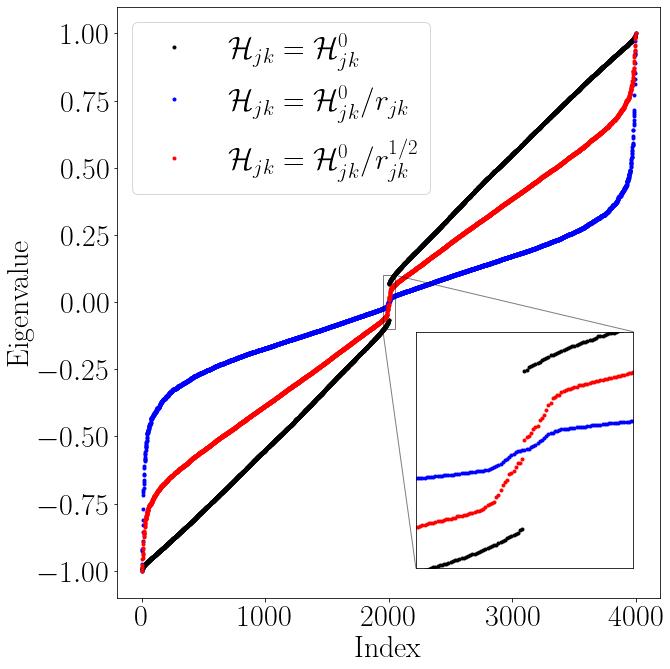

In [153]:

fig, ax = plt.subplots()

ax.plot(eig / np.max(eig), 'k.', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$')
ax.plot(dis_eig_r / np.max(dis_eig_r), 'b.', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}$')
ax.plot(dis_eig_r2 / np.max(dis_eig_r2), 'r.', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^{2}$')

axins = ax.inset_axes([0.55, 0.05, 0.4, 0.4])
axins.set_xticklabels([])
axins.set_yticklabels([])
axins.set_xticks([])
axins.set_yticks([])
axins.plot(eig / np.max(eig), 'k.')
axins.plot(dis_eig_r / np.max(dis_eig_r), 'b.')
axins.plot(dis_eig_r2 / np.max(dis_eig_r2), 'r.')
axins.set_ylim([-0.1, 0.1])
axins.set_xlim([1950, 2050])
ax.indicate_inset_zoom(axins, edgecolor='black')

ax.set_xlabel("Index")
ax.set_ylabel("Eigenvalue")
plt.legend()
plt.tight_layout()
plt.savefig("example_spectrum.pdf")
plt.savefig("example_spectrum.png")

In [113]:
def gap(eigs):
    eigsort = eigs[np.abs(eigs).argsort()] / np.max(eigs)
    return np.abs(2*eigsort[0])


system_sizes = np.logspace(1, 3, 30, dtype=np.int)
num_samples = 100

h0_gap = []
h0_r_gap = []
h0_r2_gap = []

h0_gap_store = np.zeros((len(system_sizes), num_samples))
h0_r_gap_store = np.zeros((len(system_sizes), num_samples))
h0_r2_gap_store = np.zeros((len(system_sizes), num_samples))

for system_size in tqdm(system_sizes):
    accumulator_h0 = 0
    accumulator_h0_r = 0
    accumulator_h0_r2 = 0
    for i in range(num_samples):
        points = generate_random(system_size)
        lattice = generate_lattice(points)
        coloring = color_lattice(lattice)

        all_sides = np.array([lattice.plaquettes[n].n_sides for n in range(len(lattice.plaquettes))])
        target_flux = np.int0(-((1j)**all_sides).real -(1j**all_sides).imag)
        ujk = find_flux_sector(lattice,target_flux)

        separations = lattice.vertices.positions[:, None, :] - lattice.vertices.positions[None, :, :]
        separations = np.linalg.norm(separations, axis=-1)

        ham = generate_majorana_hamiltonian(lattice, coloring, ujk)
        dis_ham_r = ham / (separations + np.eye(lattice.n_vertices))
        dis_ham_r2 = ham / (separations**2 + np.eye(lattice.n_vertices))

        eig, vec = np.linalg.eigh(ham)
        dis_eig_r, dis_vec_r = np.linalg.eigh(dis_ham_r)
        dis_eig_r2, dis_vec_r2 = np.linalg.eigh(dis_ham_r2)

        accumulator_h0 += gap(eig)
        accumulator_h0_r += gap(dis_eig_r)
        accumulator_h0_r2 += gap(dis_eig_r2)

        h0_gap_store[system_size == system_sizes, i] = gap(eig)
        h0_r_gap_store[system_size == system_sizes, i] = gap(dis_eig_r)
        h0_r2_gap_store[system_size == system_sizes, i] = gap(dis_eig_r2)
    h0_gap.append(accumulator_h0 / num_samples)
    h0_r_gap.append(accumulator_h0_r / num_samples)
    h0_r2_gap.append(accumulator_h0_r2 / num_samples)

C:\Users\Gino\AppData\Local\Temp\ipykernel_24336\3847041970.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  system_sizes = np.logspace(1, 3, 30, dtype=np.int)
100%|██████████| 30/30 [28:05<00:00, 56.19s/it] 


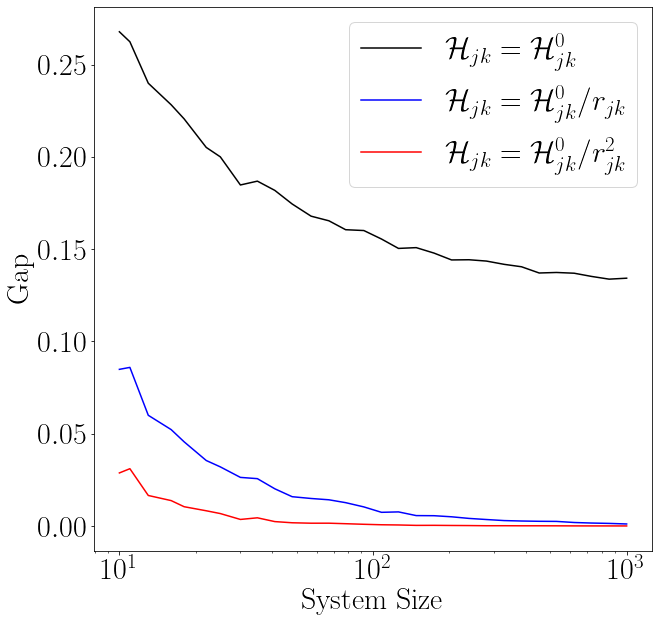

In [123]:
plt.plot(system_sizes, h0_gap, 'k-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$')
plt.plot(system_sizes, h0_r_gap, 'b-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}$')
plt.plot(system_sizes, h0_r2_gap, 'r-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^2$')
plt.legend()
plt.xlabel("System Size")
plt.ylabel("Gap")
plt.xscale('log')

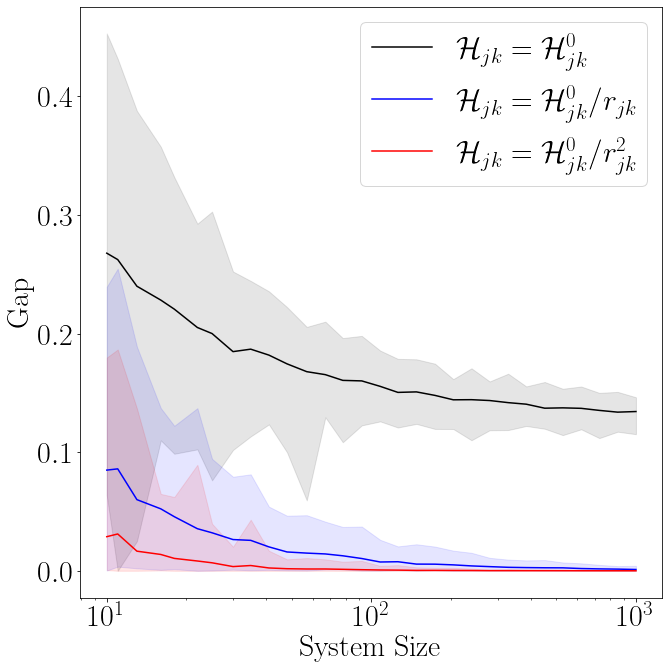

In [124]:
plt.plot(system_sizes, h0_gap, 'k-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk}$')
plt.plot(system_sizes, h0_r_gap, 'b-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}$')
plt.plot(system_sizes, h0_r2_gap, 'r-', label=r'$\mathcal{H}_{jk} = \mathcal{H}^0_{jk} / r_{jk}^2$')

h0_gap_max = np.max(h0_gap_store, axis=1)
h0_gap_min = np.min(h0_gap_store, axis=1)

h0_r_gap_max = np.max(h0_r_gap_store, axis=1)
h0_r_gap_min = np.min(h0_r_gap_store, axis=1)

h0_r2_gap_max = np.max(h0_r2_gap_store, axis=1)
h0_r2_gap_min = np.min(h0_r2_gap_store, axis=1)

plt.fill_between(system_sizes, h0_gap_min, h0_gap_max, alpha=0.1, color='k')
plt.fill_between(system_sizes, h0_r_gap_min, h0_r_gap_max, alpha=0.1, color='b')
plt.fill_between(system_sizes, h0_r2_gap_min, h0_r2_gap_max, alpha=0.1, color='r')


plt.legend()
plt.xlabel("System Size")
plt.ylabel("Gap")
plt.xscale('log')
plt.tight_layout()
plt.savefig("size_scaling.pdf")
plt.savefig("size_scaling.png")